In [ ]:
%autosave 5

Autosaving every 5 seconds


# Installing necessary libraries for RAPIDs CuGraph

In [1]:
!pip3 install cudf-cu11 --extra-index-url=https://pypi.nvidia.com
!pip3 install cuml-cu11 --extra-index-url=https://pypi.nvidia.com
!pip3 install cugraph-cu11 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.4/428.4 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 30.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 9.0.0
    Uninstalling pyarrow-9.0.0:
      Successfully uninstalled pyarrow-9.0.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.

# Importing Required Libraries

In [2]:
import networkx as nx # library to deal with Graph Algorithms
import random # library for Pseudo Random Number Generator
import matplotlib.pyplot as plt # graph plotting library
import cugraph as cnx # library with GPU accelerated Graph Algorithms

# Defining the Constants

In [3]:
N = 10000 # Total number of nodes in the final graph (Ten Thousand Nodes)
M = 50 # Size of the initial graph and the number of edges to be introduced in each time interval (Fifty)
SEED = 1682373982 # Seed is to generate the Random choices (we've taken current timestamp for this) 

# Creating the Graphs

## Defining the required algorithms

In [24]:
# Returns m unique elements from seq.
def _random_subset(seq,m):
    targets=set()
    while len(targets)<m:
        x=random.choice(seq)
        targets.add(x)
    return targets

# Returns a random graph using Barabási–Albert preferential attachment
def barabasi_albert_graph(n, m, seed=None, initial_graph=None):
    if m < 1 or  m >= n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1 and m < n, m = %d, n = %d" % (m, n))

    if seed is not None:
        random.seed(seed)

    if initial_graph is not None:
        G = initial_graph.copy()
    else:
        G = nx.empty_graph(m)

    targets = list(range(m))
    repeated_nodes = []
    
    source = m
    while source < n:
        G.add_edges_from(zip([source] * m, targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)
        targets = _random_subset(repeated_nodes, m)
        source += 1

    return G

## Creating the initial Graph

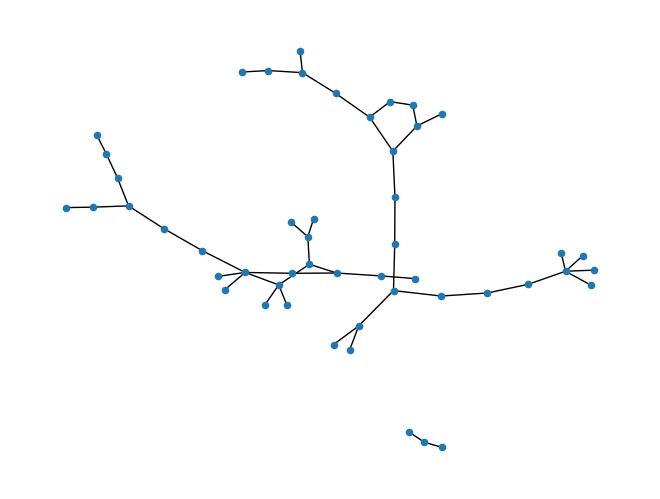

In [36]:
# storing initial graph
graph = nx.empty_graph(M)

for i in range(0, M):
    t = random.randrange(M)
    graph.add_edge(i, t)

nx.draw(graph, node_size=20)

## Creating the BA graph

In [37]:
# creating a BA Graph
G = barabasi_albert_graph(N, M, seed=SEED, initial_graph=graph)

## Degree Distribution Plot

### Plotting the Degree Distribution in log-log scales

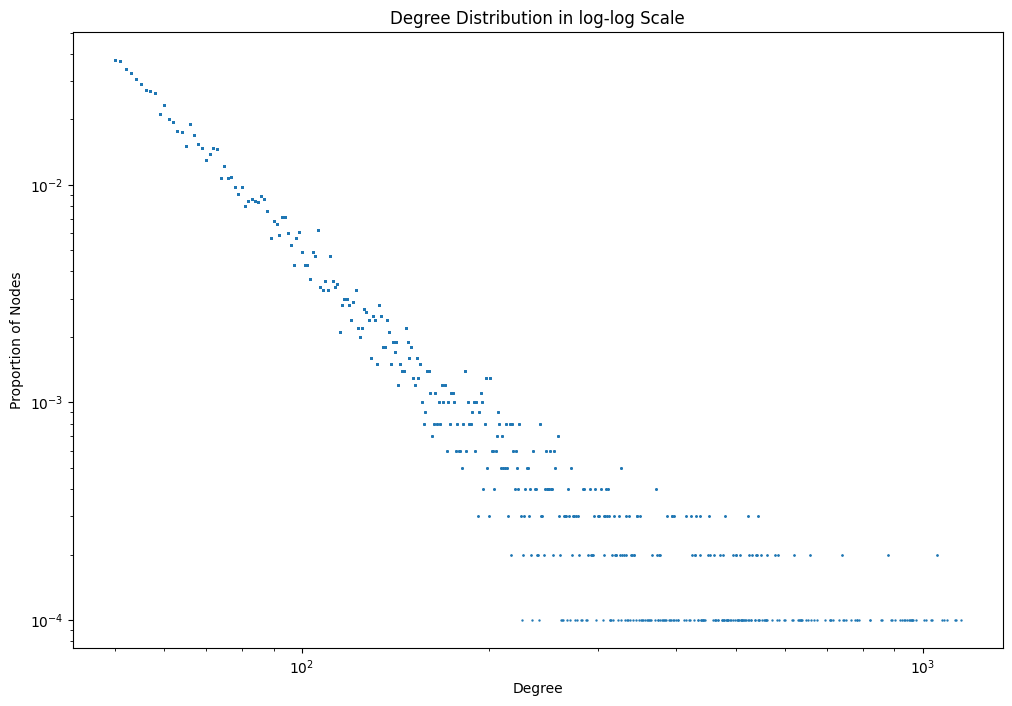

In [ ]:
# degree distribution of nodes plotted in log-log scale
deg = dict(G.degree())
degrees = sorted(list(deg.values()), reverse=False)
prop = [degrees.count(v) / N for v in degrees]
plt.figure(figsize=(12, 8))
plt.scatter(degrees, prop, s=0.5)
plt.title("Degree Distribution in log-log Scale")
plt.xlabel('Degree')
plt.ylabel("Proportion of Nodes")
plt.xscale('log')
plt.yscale('log')
plt.show()

### Degree Distribution Plot in Normal scales

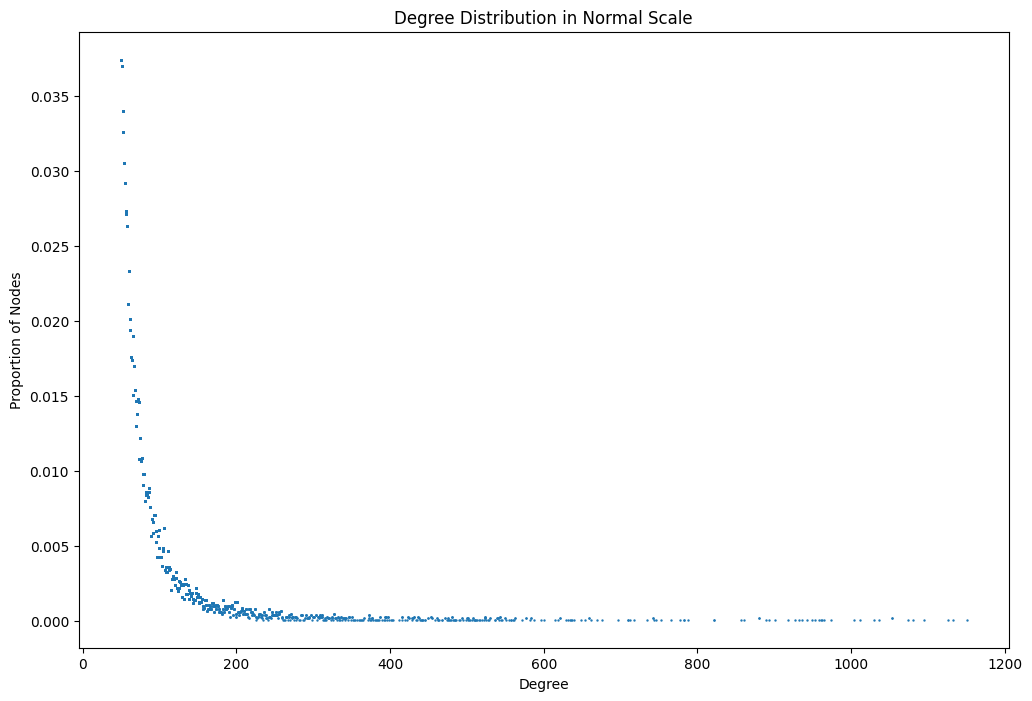

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(degrees, prop, s=0.5)
plt.title("Degree Distribution in Normal Scale")
plt.xlabel('Degree')
plt.ylabel("Proportion of Nodes")
plt.show()

### Finding the node with Maximum degree

In [ ]:
max_deg_node = max(deg, key=deg.get) # storing node with highest degree
print('Node with highest degree:', max_deg_node, "with degree:", deg[max_deg_node])
# finding the time at which it was introduced in the graph
print('Time Interval when node', max_deg_node, 'was:', int(max_deg_node - M))

Node with highest degree: 52 with degree: 1150
Time Interval when node 52 was: 2


## Plotting the degree of a node and the time when the node with that degree appeared in the graph

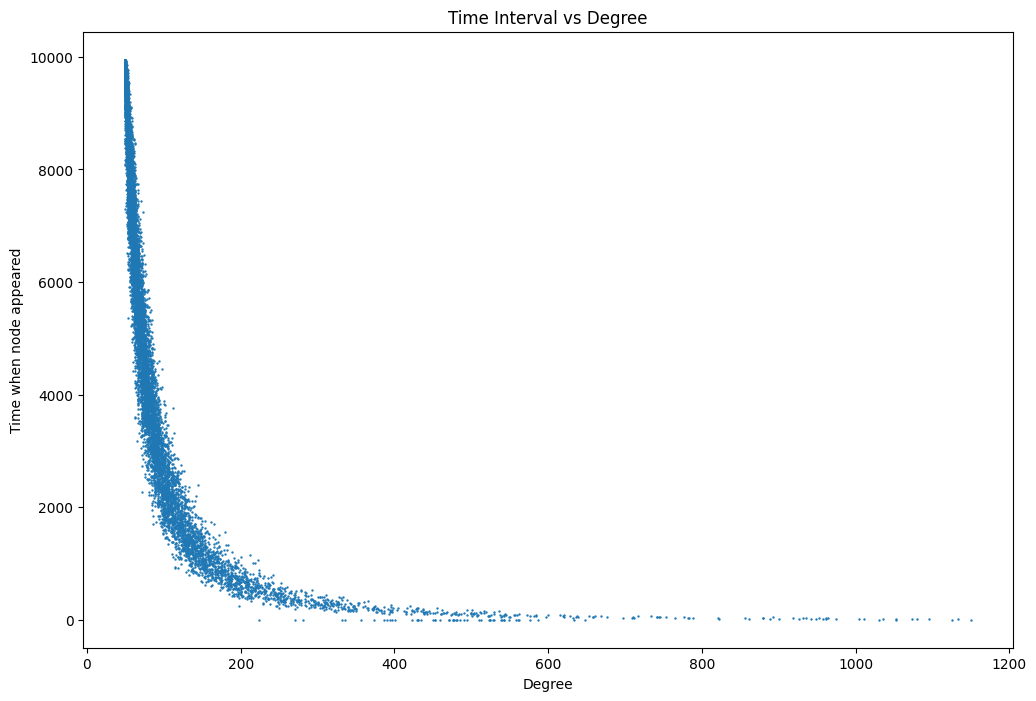

In [ ]:
plt.figure(figsize=(12, 8))
deg = dict(G.degree())
plt.title("Time Interval vs Degree")
plt.scatter(list(deg.values()), [max(0, x - M) for x in list(deg.keys())], s=0.5)
plt.xlabel('Degree')
plt.ylabel("Time when node appeared")
plt.show()

# Plots of different measures of Centrality

## Degree Centrality

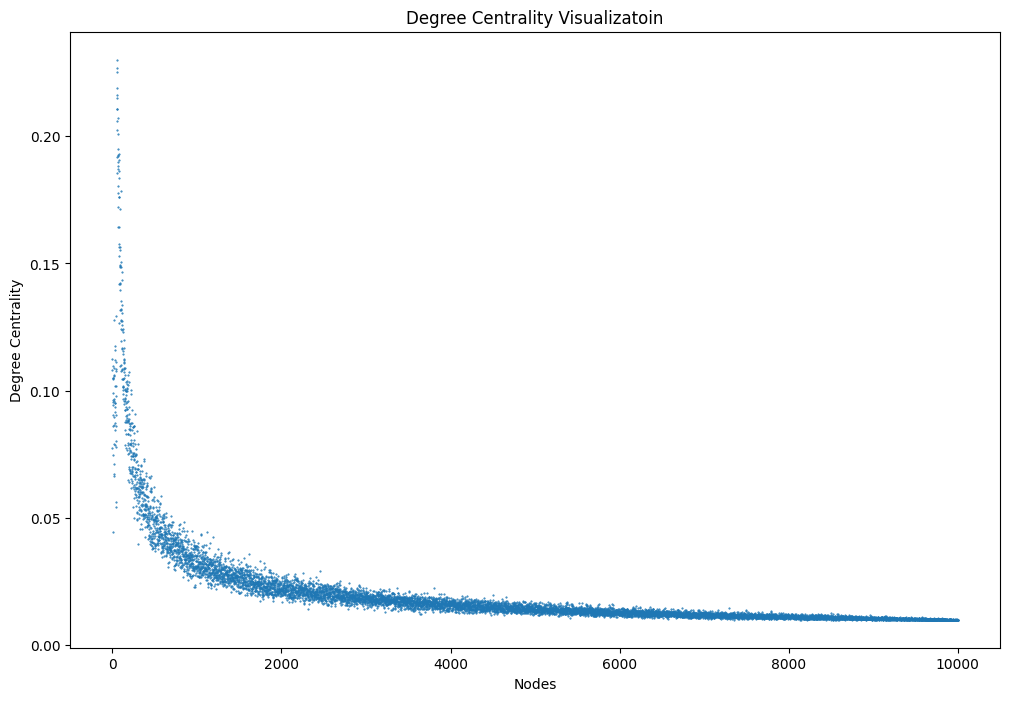

In [45]:
deg_centrality = cnx.degree_centrality(G) # calculate Degree Centrality

plt.figure(figsize=(12, 8))
plt.plot(list(deg_centrality.keys()), list(deg_centrality.values()), '-o', linewidth=0, markersize=0.5)
plt.title("Degree Centrality Visualizatoin")
plt.xlabel('Nodes')
plt.ylabel("Degree Centrality")
plt.show()

In [46]:
print("Maximum value of Degree Centrality is", max(deg_centrality.values()))

Maximum value of Degree Centrality is 0.23002299666404724


## Eigenvector Centrality

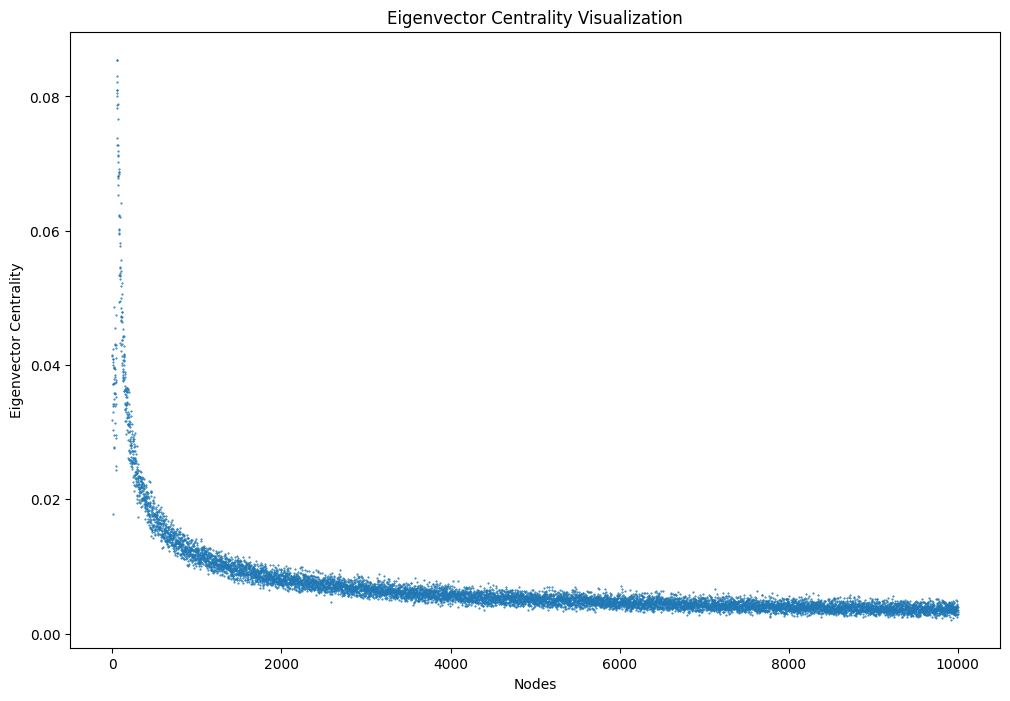

In [48]:
eigenvector_centrality = cnx.eigenvector_centrality(G) # Calculate Eigenvector centrality

plt.figure(figsize=(12, 8))
plt.plot(list(eigenvector_centrality.keys()), list(eigenvector_centrality.values()), '-o', linewidth=0, markersize=0.5)
plt.title("Eigenvector Centrality Visualization")
plt.xlabel('Nodes')
plt.ylabel("Eigenvector Centrality")
plt.show()

In [49]:
print("Maximum value of Eigenvector Centrality is", max(eigenvector_centrality.values()))

Maximum value of Eigenvector Centrality is 0.08546853065490723


## Katz Centrality

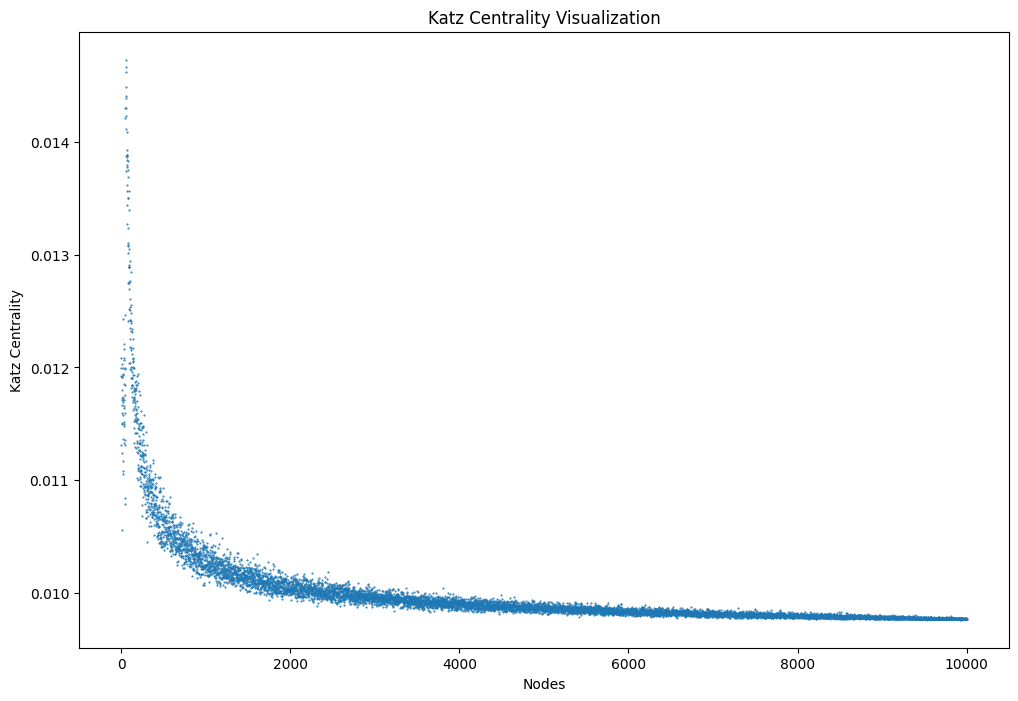

In [51]:
katz_centrality = cnx.katz_centrality(G) # Calculate Katz Centrality

plt.figure(figsize=(12, 8))
plt.plot(list(katz_centrality.keys()), list(katz_centrality.values()), '-o', linewidth=0, markersize=0.5)
plt.title("Katz Centrality Visualization")
plt.xlabel('Nodes')
plt.ylabel("Katz Centrality")
plt.show()

In [52]:
print("Maximum value of Katz Centrality is", max(katz_centrality.values()))

Maximum value of Katz Centrality is 0.014732152223587036


## Pagerank

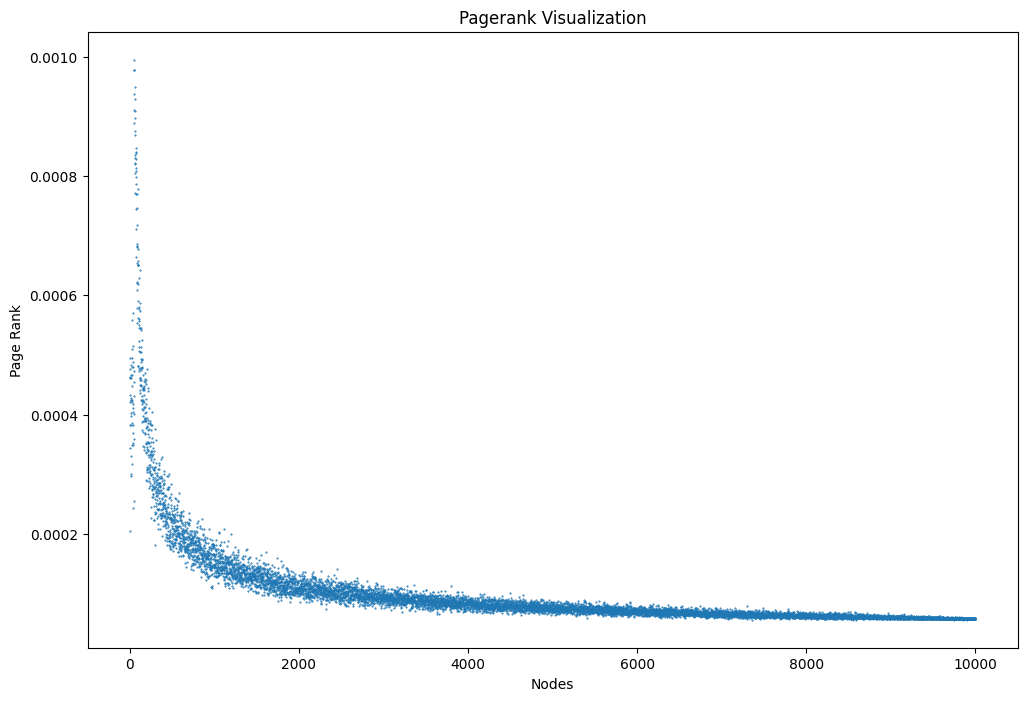

In [53]:
pagerank = nx.pagerank(G) # calculate the Pagerank

plt.figure(figsize=(12, 8))
plt.plot(list(pagerank.keys()), list(pagerank.values()), '-o', linewidth=0, markersize=0.5)
plt.title("Pagerank Visualization")
plt.xlabel('Nodes')
plt.ylabel("Page Rank")
plt.show()

In [54]:
print("Maximum value of PageRank Centrality is", max(pagerank.values()))

Maximum value of PageRank Centrality is 0.0009950134828010469


## Closeness Centrality

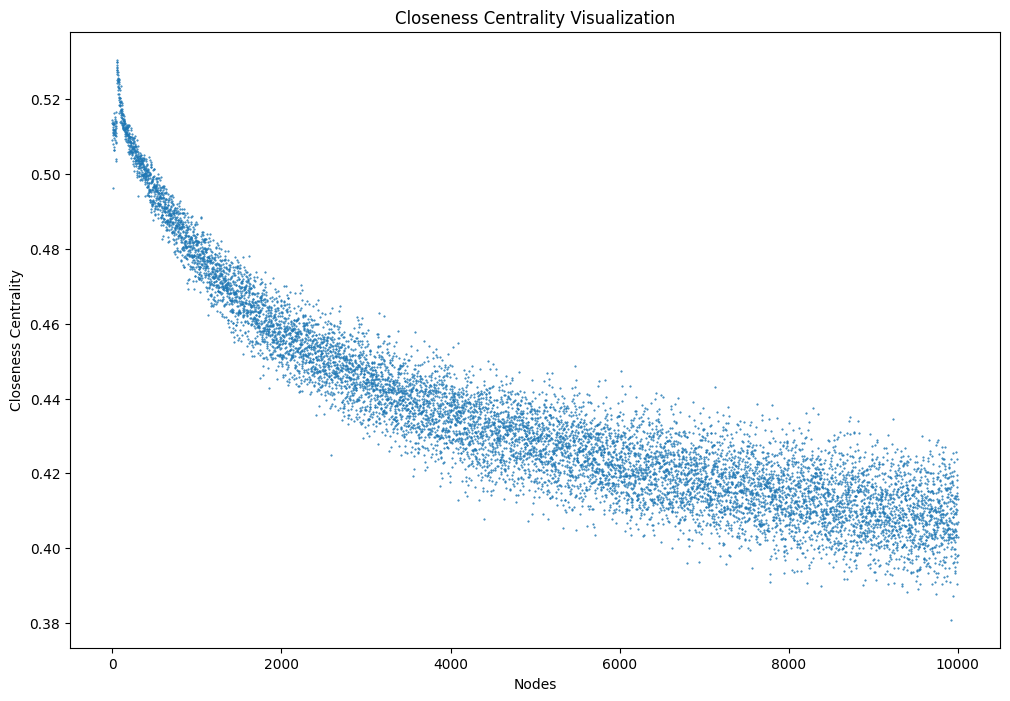

In [55]:
closeness_centrality = nx.closeness_centrality(G) # Calculating the closeness Centrality

plt.figure(figsize=(12, 8))
plt.plot(list(closeness_centrality.keys()), list(closeness_centrality.values()), '-o', linewidth=0, markersize=0.5)
plt.title("Closeness Centrality Visualization")
plt.xlabel('Nodes')
plt.ylabel("Closeness Centrality")
plt.show()

In [58]:
print("Maximum value of Closeness Centrality is", max(closeness_centrality.values()))

Maximum value of Closeness Centrality is 0.5305072156196944


## Betweenness Centrality

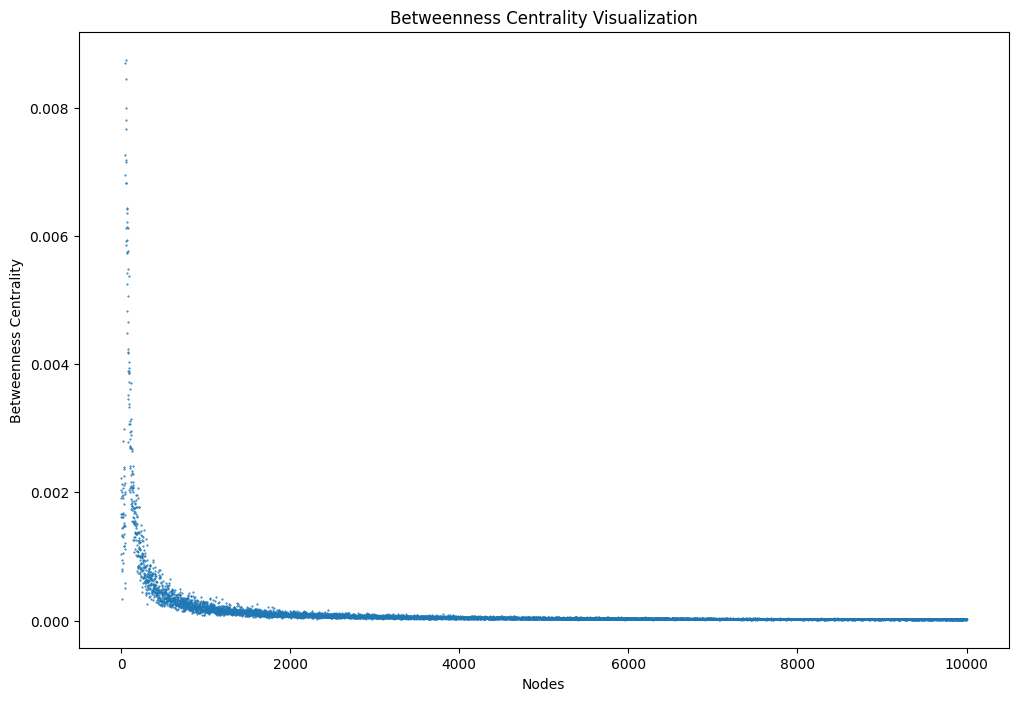

In [57]:
betweenness_centrality = cnx.betweenness_centrality(G) # Calculate the Betweenness Centrality

plt.figure(figsize=(12, 8))
plt.plot(list(betweenness_centrality.keys()), list(betweenness_centrality.values()), '-o', linewidth=0, markersize=0.5)
plt.title("Betweenness Centrality Visualization")
plt.xlabel('Nodes')
plt.ylabel("Betweenness Centrality")
plt.show()

In [59]:
print("Maximum value of Betweenness Centrality is", max(closeness_centrality.values()))

Maximum value of Betweenness Centrality is 0.5305072156196944


# Giant Component

## Finding the Giant component and find the ratio of both's size

In [ ]:
sorted_comps = sorted(nx.connected_components(G), key=len, reverse=True) 
giant_comp = G.subgraph(sorted_comps[0]) # finding the largest connected component

ratio = (len(giant_comp.nodes())) / (len(G.nodes())) # calculate its ratio
print("The ratio of size of Giant component to Graph is:", ratio)

The ratio of size of Giant component to Graph is: 1.0


# Independent Cascade Model

## Finding the average number of steps required to spread the information to maximum nodes

In [43]:
# Independent Cascade algorithm
def independent_cascade(G, src, p):
  steps = 0
  activated_set = set({src})
  cur_set = [src]

  while len(cur_set) != 0:
    steps += 1
    new_cur_set = []
    
    for n in cur_set:
      not_activated_set = set()
      for x in G[n]:
       if x not in activated_set:
         not_activated_set.add(x)

      for neighbor in not_activated_set:
        rand_int = random.random()
        if rand_int <= p:
          activated_set.add(neighbor)
          new_cur_set.append(neighbor)

    cur_set = new_cur_set

  return steps

for prob in [0.25, 0.5, 0.75, 1]:  # probability of spread of information
  avg = 0
  print("For pobability",prob,"the steps we get in 15 experiments are as follows:")
  for z in range(15):
    src = random.randrange(N) # selecting a random node
    count=independent_cascade(G, src, prob)
    avg += count;
    print(count,' ', end="")

  print("And their average is:",avg/15)

For pobability 0.25 the steps we get in 15 experiments are as follows:
5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  And their average is: 4.933333333333334
For pobability 0.5 the steps we get in 15 experiments are as follows:
4  5  4  4  4  4  4  4  4  4  4  4  4  4  4  And their average is: 4.066666666666666
For pobability 0.75 the steps we get in 15 experiments are as follows:
4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  And their average is: 4.0
For pobability 1 the steps we get in 15 experiments are as follows:
4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  And their average is: 4.0
